In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from Model_seed_vector import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100

In [3]:
# place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
# model = Model(
#     N_inp, N_bar, num_states,
#     rec_strength=0.0, weight_bias=0.,
#     divisive_normalization=20.0, steps=100, seed_steps=5, seed_strength_cache=3.0,# dynamics
#     lr=50.0, plasticity_bias = -0.65, # Learning
#     )

In [36]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    rec_strength=0.0, weight_bias=0.,
    )

In [37]:
cache_states = [20,30, 70]

# Example Narrow/Broad Recall

In [40]:
def get_snr(readout, cache_states):
    readout = np.linalg.norm(readout, axis=1)
    readout /= readout.max()
    idxs = np.zeros(readout.size).astype(bool)
    for c in cache_states:
        idxs[c] = True
    signal_strength = np.sum(readout[idxs])
    noise_strength = np.sum(readout[np.logical_not(idxs)])
    snr = 10 * np.log10(signal_strength/noise_strength)
    return snr

In [41]:
def recall_plots(cache_identification, narrow_recall, wide_recall):
    fig, ax = plt.subplots(
        1, 3, figsize=(8,2.),
        )
    
    # Identification plot
    readout = np.linalg.norm(cache_identification, axis=1)
    readout /= readout.max()
    ax[0].plot(readout)
    threshold=0.75
    idxs = readout > threshold
    y = readout[idxs]
    y[y>0] = 1.05
    ax[0].scatter(np.arange(100)[idxs], y, s=1, color='red')
    ax[0].set_yticks([0, 0.50, 1.0])
    ax[0].set_ylabel('Output Norm')
    
    # Narrow recall plot
    reconstruct = narrow_recall
    valid_recall = np.any(reconstruct > reconstruct.mean() + 1.5*reconstruct.std(), axis=1)
    offset = reconstruct.std()/2
    for idx, validity in enumerate(valid_recall):
        if not validity: continue
        r = reconstruct[idx]
        ax[1].plot(np.arange(r.size), r-offset*idx, color='black', linewidth=0.5)
    ax[1].set_yticks([0, -offset*(num_states//2), -offset*(num_states)], [0, '$\pi$', '$2\pi$'])
    
    # Wide recall plot
    reconstruct = wide_recall
    valid_recall = np.any(reconstruct > reconstruct.mean() + 1.5*reconstruct.std(), axis=1)
    offset = reconstruct.std()/2
    for idx, validity in enumerate(valid_recall):
        if not validity: continue
        r = reconstruct[idx]
        ax[2].plot(np.arange(r.size), r-offset*idx, color='black', linewidth=0.5)
        
    ax[1].set_ylabel('Location')
    ax[2].set_ylabel('')
    ax[2].set_yticks([])
    for _ax in [ax[0]]: # For cache identification
        xtick_loc = []; xtick_label = [];
        for i, c in enumerate(cache_states[:c_idx+1]):
            xtick_loc.append(c)
            xtick_label.append(f'C{i+1}')
        _ax.set_xticks(xtick_loc, xtick_label, rotation=45, color='red', fontsize=10)
    for _ax in ax[1:]: # For recalled place fields
        xtick_loc = []; xtick_label = [];
        for i, c in enumerate(cache_states[:c_idx+1]):
            xtick_loc.append((c/num_states)*N_bar)
            xtick_label.append(f'C{i+1}')
        _ax.set_xticks(xtick_loc, xtick_label, rotation=45, color='red', fontsize=10)
    plt.tight_layout()
    plt.show()

Now I just cached at location: 20
-11.617119860822864


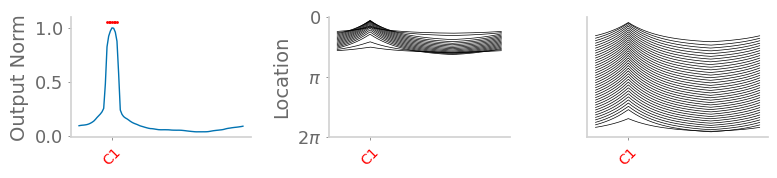

Now I just cached at location: 30
-10.0802428711816


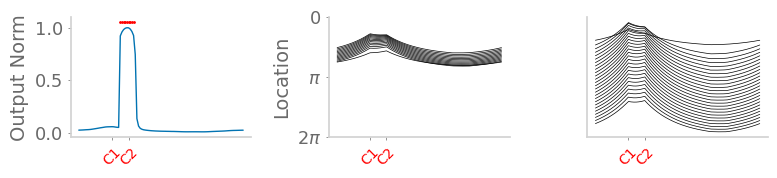

Now I just cached at location: 70
-10.02437558280841


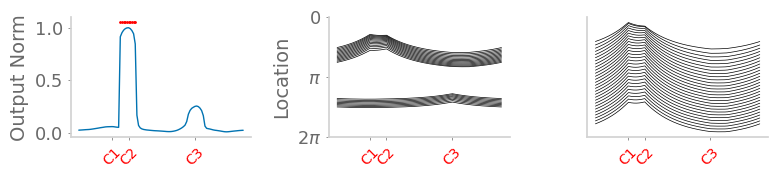

In [42]:
model.reset()

cache_identification = []
narrow_recall = []
wide_recall = []

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(0.3, place_inputs)
    cache_identification.append(_cache_identification.copy())
    print(get_snr(_cache_identification, cache_states[:c_idx+1]))
    
    _, _, _narrow_recall, _ = model.run_narrow_recall(place_inputs)
    narrow_recall.append(_narrow_recall.copy())
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    wide_recall.append(_wide_recall.copy())

    recall_plots(_cache_identification, _narrow_recall, _wide_recall)

# Cache identification SNR

In [43]:
signal_strength = []
noise_strength = []
seed_factors = np.arange(0, 0.55, 0.05)
idxs = np.zeros(readout.size).astype(bool)
idxs[20] = idxs[30] = idxs[70] = True
for s in seed_factors:
    _, _, reconstruct, _ = model.run_recall(s, place_inputs)
    readout = np.linalg.norm(reconstruct, axis=1)
    readout /= readout.max()
    signal_strength.append(np.sum(readout[idxs]))
    noise_strength.append(np.sum(readout[np.logical_not(idxs)]))

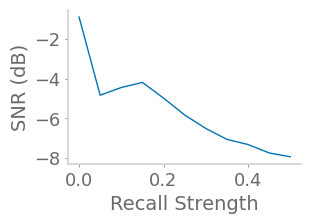

In [44]:
snrs = []
signal_bias = 4
for _signal, _noise in zip(signal_strength, noise_strength):
    snr = 10 * np.log10((_signal**signal_bias)/_noise)
    snrs.append(snr)
plt.figure(figsize=(3,2))
plt.plot(seed_factors, snrs)
plt.ylabel('SNR (dB)')
plt.xlabel('Recall Strength')
plt.show()

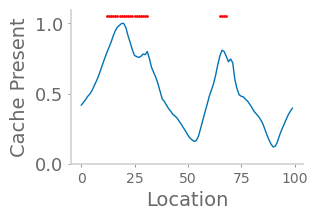

-1.2916711496735518


In [45]:
# How to just check if the current location has a seed?
_, acts, reconstruct, a_over_time = model.run_recall(0., place_inputs)
readout = np.linalg.norm(reconstruct, axis=1)
readout /= readout.max()
plt.figure(figsize=(3,2))
plt.xticks([0,20,30,50,70,100], fontsize=10)
plt.plot(readout)
threshold=0.75
idxs = readout > threshold
y = readout[idxs]
y[y>0] = 1.05
plt.scatter(np.arange(100)[idxs], y, s=1, color='red')
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0, 0.50, 1.0])
plt.ylabel('Cache Present')
plt.xlabel('Location')
plt.show()

idxs = np.zeros(readout.size).astype(bool)
idxs[20] = idxs[30] = idxs[70] = True
snr = np.log10(np.sum(readout[idxs])/np.sum(readout[np.logical_not(idxs)]))
print(snr)

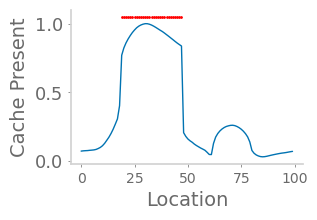

-1.2139374990764082


In [46]:
# How to just check if the current location has a seed?
_, acts, reconstruct, a_over_time = model.run_recall(1., place_inputs)
readout = np.linalg.norm(reconstruct, axis=1)
readout /= readout.max()
plt.figure(figsize=(3,2))
plt.xticks([0,20,30,50,70,100], fontsize=10)
plt.plot(readout)
threshold=0.75
idxs = readout > threshold
y = readout[idxs]
y[y>0] = 1.05
plt.scatter(np.arange(100)[idxs], y, s=1, color='red')
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0, 0.50, 1.0])
plt.ylabel('Cache Present')
plt.xlabel('Location')
plt.show()

idxs = np.zeros(readout.size).astype(bool)
idxs[20] = idxs[30] = idxs[70] = True
snr = np.log10(np.sum(readout[idxs])/np.sum(readout[np.logical_not(idxs)]))
print(snr)